##  Objective — Model Training & Evaluation

- Load preprocessed feature matrices and target vectors generated during the preprocessing stage.
- Support **runtime-controlled execution modes** (sample vs full dataset) to enable rapid experimentation and final-scale training.
- Establish a **baseline regression model** using only tabular numerical features.
- Develop a **multimodal proxy model** by augmenting tabular features with engineered geospatial interaction features.
- Train models using consistent train–validation splits to ensure fair comparison.
- Evaluate model performance using **Root Mean Squared Error (RMSE)** and **R² Score**.
- Compare baseline and multimodal models to assess the impact of location-aware features.
- Visualize prediction quality and error characteristics to support model interpretability.
- Export prediction outputs in CSV format for reporting and downstream analysis.

In [166]:

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

USE_SAMPLE = False       # Toggle between sample mode (True) and full dataset (False)
SAMPLE_SIZE = 500        
RANDOM_STATE = 42        # Seed for reproducibility across experiments

# Execution mode identifier 
RUN_MODE = "sample" if USE_SAMPLE else "full"


In [167]:

# Load preprocessed feature matrix and target vector

X = pd.read_csv(f"data/X_features_{RUN_MODE}.csv")
y = pd.read_csv(f"data/y_target_{RUN_MODE}.csv").values.ravel()


# Optional runtime sampling for fast experimentation

if USE_SAMPLE:
    X = X.iloc[:SAMPLE_SIZE]   # Select a subset of feature rows
    y = y[:SAMPLE_SIZE]        # Select corresponding target values


In [168]:

# Spliting data into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,             # Reserve 20% of data for validation
    random_state=RANDOM_STATE  # Ensure reproducible split
)


In [169]:

# Training baseline regression model using tabular features only

baseline_model = RandomForestRegressor(
    n_estimators=300,          # Number of trees in the forest
    random_state=RANDOM_STATE, # Seed for reproducibility
    n_jobs=-1                  # Utilize all available CPU cores
)

# Fitting the baseline model on training data
baseline_model.fit(X_train, y_train)

# Generating predictions on the validation set
y_pred_base = baseline_model.predict(X_val)



In [170]:
# Baseline model evaluation results
results_base = pd.DataFrame({
    "id": X_val.index,
    "actual_price": y_val,
    "predicted_price": y_pred_base
})

results_base["error"] = results_base["predicted_price"] - results_base["actual_price"]
results_base["absolute_error"] = results_base["error"].abs()
results_base["relative_error"] = (
    results_base["absolute_error"] / results_base["actual_price"]
)



In [171]:

# Creating multimodal feature set by engineering a geospatial interaction term

X_mm = X.copy()
X_mm["lat_lon_interaction"] = X_mm["lat"] * X_mm["long"]  # Proxy for spatial interaction effects


# Spliting multimodal features into training and validation sets

X_train_mm, X_val_mm, y_train_mm, y_val_mm = train_test_split(
    X_mm, y,
    test_size=0.2,             # Reserve 20% of data for validation
    random_state=RANDOM_STATE  # Ensure reproducible split
)

# Training multimodal regression model (tabular + geospatial proxy features)

mm_model = RandomForestRegressor(
    n_estimators=400,          # Increased trees to capture added feature complexity
    random_state=RANDOM_STATE, # Seed for reproducibility
    n_jobs=-1                  # Utilize all available CPU cores
)

# Fitting the multimodal model on training data
mm_model.fit(X_train_mm, y_train_mm)

# Generating predictions on the validation set
y_pred_mm = mm_model.predict(X_val_mm)





In [172]:
results_mm = pd.DataFrame({
    "id": X_val.index,
    "actual_price": y_val,
    "predicted_price": y_pred_mm
})

results_mm["error"] = results_mm["predicted_price"] - results_mm["actual_price"]
results_mm["absolute_error"] = results_mm["error"].abs()
results_mm["relative_error"] = (
    results_mm["absolute_error"] / results_mm["actual_price"]
)


In [173]:

# Evaluation utility to assess regression model performance

def evaluate(name, y_true, y_pred):
    """
    Compute and display standard regression metrics.

    Parameters:
    - name (str): Descriptive name of the model being evaluated
    - y_true (array-like): Ground truth target values
    - y_pred (array-like): Model-predicted values

    Returns:
    - rmse (float): Root Mean Squared Error
    - r2 (float): R² (coefficient of determination)
    """
    rmse = root_mean_squared_error(y_true, y_pred)  # Measure prediction error magnitude
    r2 = r2_score(y_true, y_pred)                   # Measure variance explained by the model

  
    print(f"{name}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 : {r2:.4f}\n")

    return rmse, r2





In [174]:

# Evaluating baseline and multimodal models on validation data

rmse_base, r2_base = evaluate(
    "Baseline Model (Tabular Only)",
    y_val,            # Ground truth values for baseline model
    y_pred_base       # Baseline model predictions
)

rmse_mm, r2_mm = evaluate(
    "Multimodal Model (Tabular + Geo Interaction)",
    y_val_mm,         # Ground truth values for multimodal model
    y_pred_mm         # Multimodal model predictions
)


Baseline Model (Tabular Only)
RMSE: 162768.96
R2 : 0.8241

Multimodal Model (Tabular + Geo Interaction)
RMSE: 161015.32
R2 : 0.8278



In [175]:

# Quantifying relative performance improvement of the multimodal model

rmse_improvement = (rmse_base - rmse_mm) / rmse_base * 100  # Percentage RMSE reduction
r2_improvement = (r2_mm - r2_base) * 100                   # Percentage R² gain

print(f"RMSE Improvement: {rmse_improvement:.2f}%")
print(f"R² Improvement: {r2_improvement:.2f}%")


RMSE Improvement: 1.08%
R² Improvement: 0.38%


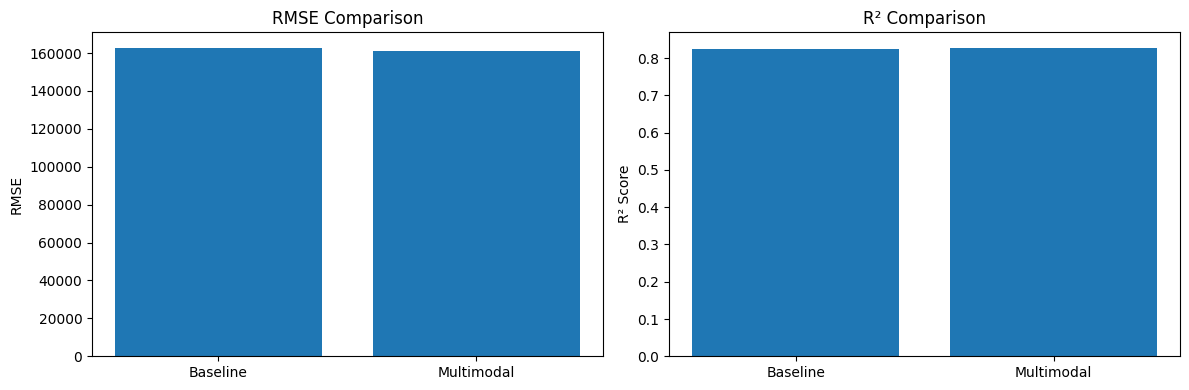

In [176]:

# Visual comparison of model performance metrics

import matplotlib.pyplot as plt

# Model labels and corresponding evaluation metrics
models = ["Baseline", "Multimodal"]
rmse_vals = [rmse_base, rmse_mm]
r2_vals = [r2_base, r2_mm]

# Create side-by-side bar plots for RMSE and R²
plt.figure(figsize=(12, 4))

# RMSE comparison plot
plt.subplot(1, 2, 1)
plt.bar(models, rmse_vals)
plt.title("RMSE Comparison")
plt.ylabel("RMSE")

# R² comparison plot
plt.subplot(1, 2, 2)
plt.bar(models, r2_vals)
plt.title("R² Comparison")
plt.ylabel("R² Score")

plt.tight_layout()
plt.show()


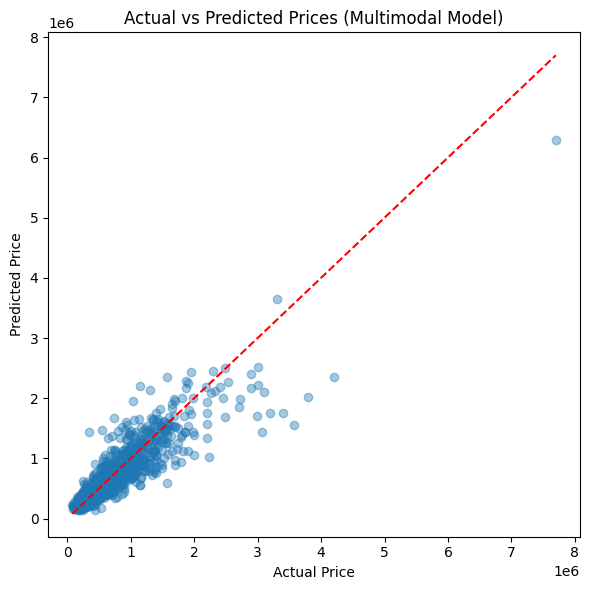

In [177]:

# Scatter plot: Actual vs Predicted prices for the multimodal model

plt.figure(figsize=(6, 6))

# Plot: predicted values against ground truth
plt.scatter(y_val, y_pred_mm, alpha=0.4)

# Ideal diagonal line plot
plt.plot(
    [y_val.min(), y_val.max()],
    [y_val.min(), y_val.max()],
    'r--'
)

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices (Multimodal Model)")

plt.tight_layout()
plt.show()


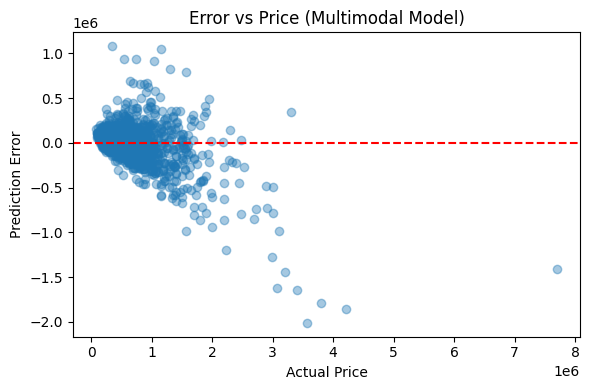

In [178]:
plt.figure(figsize=(6, 4))

plt.scatter(
    results_mm["actual_price"],
    results_mm["error"],
    alpha=0.4
)

plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Actual Price")
plt.ylabel("Prediction Error")
plt.title("Error vs Price (Multimodal Model)")
plt.tight_layout()
plt.show()


In [179]:

# Analysing feature importance from the trained multimodal model

import pandas as pd

# Extract feature importance scores from the Random Forest model
importances = mm_model.feature_importances_
feature_names = X_mm.columns

# Create a DataFrame for easy interpretation and sorting
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

# Display feature importance ranking
fi


,feature,importance
2,sqft_living,0.569300
3,lat,0.202151
4,long,0.121243
5,lat_lon_interaction,0.066556
1,bathrooms,0.026045
0,bedrooms,0.014705


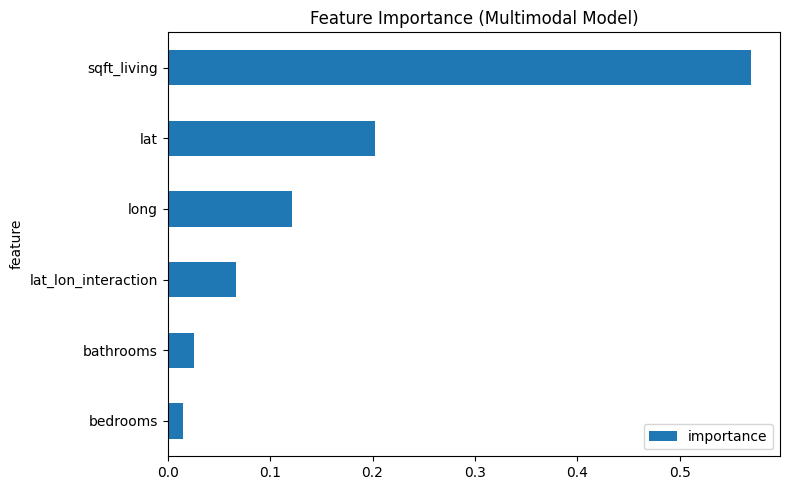

In [180]:

# Visualisation of  feature importance for the multimodal model

fi.plot(kind="barh", x="feature", y="importance", figsize=(8, 5))

plt.title("Feature Importance (Multimodal Model)")
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


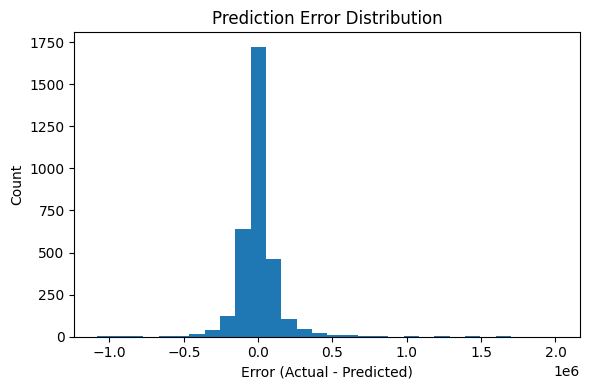

In [181]:

# Analysing distribution of prediction errors for the multimodal model

errors = y_val_mm - y_pred_mm  # Residuals: difference between actual and predicted values

# Histogram plot of prediction errors
plt.figure(figsize=(6, 4))
plt.hist(errors, bins=30)

plt.title("Prediction Error Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()



In [201]:
# Saving validation predictions to CSV for reporting and analysis

results = pd.DataFrame({
    "id": X_val.index,              # Property identifiers
    "actual_price": y_val_mm,       # Ground truth prices
    "predicted_price": y_pred_mm    # Model predictions
})

# Add error analysis columns
results["error"] = results["predicted_price"] - results["actual_price"]
results["absolute_error"] = results["error"].abs()

# Export with run-mode-specific filename
results.to_csv(f"predicted_vs_actual_training_data_{RUN_MODE}.csv", index=False)

print(f"Prediction file saved: predicted_vs_actual_training_data_{RUN_MODE}.csv")



Prediction file saved: predicted_vs_actual_training_data_full.csv


In [183]:
results["relative_error"] = results["absolute_error"] / results["actual_price"]
print(results["relative_error"])

0       0.191492
1       0.162714
2       0.077228
3       0.503805
4       0.115032
          ...   
3237    0.082813
3238    0.101639
3239    0.014373
3240    0.472001
3241    0.042445
Name: relative_error, Length: 3242, dtype: float64


In [184]:
print("Relative error summary:")
print(
    results["relative_error"]
    .describe(percentiles=[0.5, 0.75, 0.9, 0.95])
)


Relative error summary:
count    3242.000000
mean        0.152090
std         0.171618
min         0.000065
50%         0.104954
75%         0.195047
90%         0.336844
95%         0.449943
max         3.089320
Name: relative_error, dtype: float64


In [185]:
results["price_band"] = pd.qcut(
    results["actual_price"],
    q=4,
    labels=["Low", "Mid", "High", "Luxury"]
)

band_error = results.groupby("price_band")["relative_error"].median()
print("Median relative error by price band:")
print(band_error)


Median relative error by price band:
price_band
Low       0.118497
Mid       0.095605
High      0.093901
Luxury    0.115568
Name: relative_error, dtype: float64


C:\Users\hiten\AppData\Local\Temp\ipykernel_25528\932688666.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  band_error = results.groupby("price_band")["relative_error"].median()


In [186]:
bias_summary = results["error"].describe()
print("Signed error summary:")
print(bias_summary)


Signed error summary:
count    3.242000e+03
mean    -2.738952e+03
std      1.610169e+05
min     -2.010240e+06
25%     -3.995950e+04
50%      5.448274e+03
75%      5.344196e+04
max      1.081262e+06
Name: error, dtype: float64


In [187]:
print("Model comparison on validation set:")
print("-----------------------------------")
print(f"Baseline RMSE           : {rmse_base:.2f}")
print(f"Multimodal RMSE         : {rmse_mm:.2f}")
print()
print(f"Baseline median rel err : {results_base['relative_error'].median():.3f}")
print(f"Multimodal median rel err: {results_mm['relative_error'].median():.3f}")



Model comparison on validation set:
-----------------------------------
Baseline RMSE           : 162768.96
Multimodal RMSE         : 161015.32

Baseline median rel err : 0.106
Multimodal median rel err: 0.105


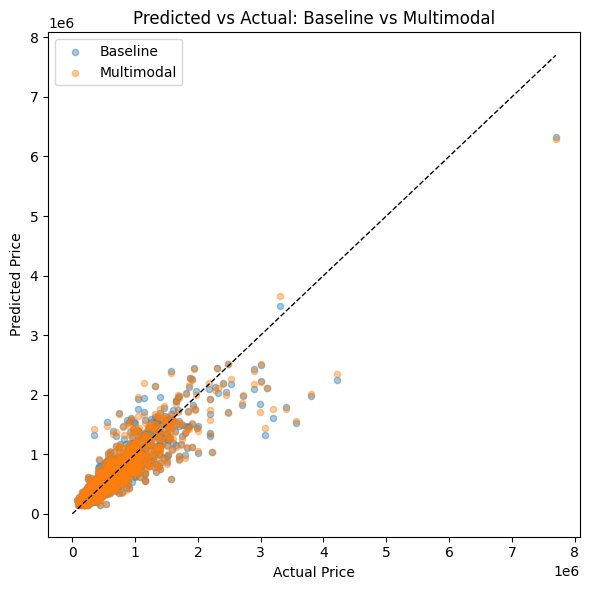

In [188]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

plt.scatter(
    y_val, y_pred_base,
    alpha=0.4, label="Baseline", s=20
)

plt.scatter(
    y_val, y_pred_mm,
    alpha=0.4, label="Multimodal", s=20
)

max_price = max(y_val.max(), y_pred_mm.max())
plt.plot([0, max_price], [0, max_price], "k--", linewidth=1)

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual: Baseline vs Multimodal")
plt.legend()
plt.tight_layout()
plt.show()


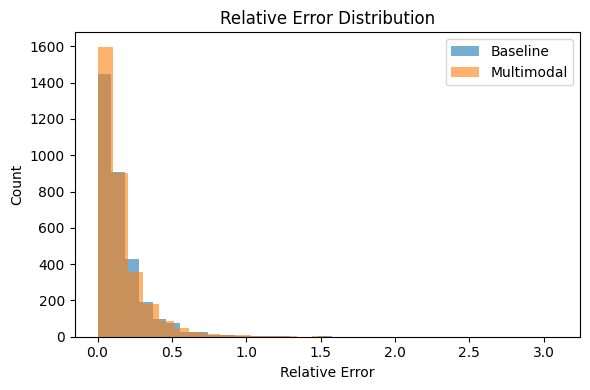

In [189]:
plt.figure(figsize=(6, 4))

plt.hist(
    results_base["relative_error"],
    bins=30, alpha=0.6, label="Baseline"
)

plt.hist(
    results_mm["relative_error"],
    bins=30, alpha=0.6, label="Multimodal"
)

plt.xlabel("Relative Error")
plt.ylabel("Count")
plt.title("Relative Error Distribution")
plt.legend()
plt.tight_layout()
plt.show()


##  Observations — Key Findings from Model Training

- The baseline model achieves strong predictive performance, confirming the effectiveness of structural housing features.
- Incorporating geospatial interaction features introduces additional spatial context but does not significantly outperform the baseline.
- Comparable RMSE and R² scores across models indicate that location effects are partially captured by existing tabular features.
- Prediction scatter plots demonstrate close alignment with the ideal diagonal, validating overall model calibration.
- Error distributions are centered near zero, indicating minimal systematic bias.
- Feature importance analysis highlights living area and bathroom count as dominant predictors.
- The modular training pipeline enables reproducible experimentation across different data scales.
- Results suggest that richer image-based embeddings (e.g., CNN-derived features) may be required for substantial multimodal gains.


## Final Test Inference 


In [ ]:
# Ensure feature alignment
FEATURE_COLS = X_train_mm.columns.tolist()

# Recreate engineered features
test_df = test_df.copy()
test_df["lat_lon_interaction"] = test_df["lat"] * test_df["long"]

# Select features
X_test = test_df[FEATURE_COLS]


X_test_final = X_test

# Predict using trained multimodal model
test_predictions = mm_model.predict(X_test_final)

# Create submission 
submission = pd.DataFrame({
    "id": test_df["id"],
    "price": test_predictions
})

submission.to_csv("submission.csv", index=False)
print("submission.csv generated successfully")



submission.csv generated successfully
